# Entrenamiento de Agentes de RL en CartPole

Esta notebook permite entrenar y visualizar diferentes tipos de agentes de aprendizaje por refuerzo en el entorno CartPole:
- DQN (Deep Q-Network)
- Double DQN
- Dueling DQN

In [1]:
import os
import gymnasium as gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import animation
from dataclasses import dataclass
from agents.dqn_agent import DQNAgent
from agents.double_dqn_agent import DDQN
from agents.dueling_dqn_agent import DuelingDQNAgent

# Configurar estilo de gráficos
plt.style.use('default')
%matplotlib inline

c:\Repos\MIA\RL2\.venv-tf-gym\Lib\site-packages\gymnasium\envs\registration.py:644: UserWarning: WARN: Overriding environment CartPole-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


## Configuración

Definimos las clases y funciones necesarias para el entrenamiento.

In [2]:
@dataclass
class Config:
    """Configuración para los agentes de aprendizaje por refuerzo."""
    environment: gym.Env
    hyperparameters: dict
    seed: int = 42
    debug_mode: bool = False
    use_GPU: bool = torch.cuda.is_available()
    visualise_individual_results: bool = True

def create_agent(agent_type, config):
    """Crea un agente del tipo especificado."""
    agents = {
        'dqn': DQNAgent,
        'double_dqn': DDQN,
        'dueling_dqn': DuelingDQNAgent
    }
    
    if agent_type not in agents:
        raise ValueError(f'Tipo de agente no válido: {agent_type}')
        
    return agents[agent_type](config)

def get_default_config(env):
    """Obtiene la configuración por defecto para el agente."""
    hyperparameters = {
        "buffer_size": 100000,
        "batch_size": 64,
        "linear_hidden_units": [64, 64],
        "learning_rate": 0.001,
        "gamma": 0.99,
        "tau": 0.001,
        "update_every": 4,
        "gradient_clipping_norm": 0.5,
        "epsilon_decay_rate_denominator": 200
    }
    
    return Config(
        environment=env,
        hyperparameters=hyperparameters,
        seed=42,
        debug_mode=False
    )

## Funciones de Entrenamiento y Visualización

In [3]:
def record_video(env, agent, video_path, num_episodes=3):
    """Graba un video del agente actuando en el entorno."""
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    frames = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        
        while not done:
            frames.append(env.render())
            action = agent.pick_action(state)
            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
    
    env.close()
    
    # Guardar video como GIF
    os.makedirs(os.path.dirname(video_path), exist_ok=True)
    
    fig = plt.figure()
    plt.axis('off')
    
    def animate(i):
        plt.imshow(frames[i])
        return plt.gcf()
    
    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
    anim.save(video_path, writer='pillow')
    plt.close()
    
    return frames  # Para mostrar en la notebook

def plot_training_results(scores, moving_averages, window_size, agent_type):
    """Grafica los resultados del entrenamiento."""
    plt.figure(figsize=(12, 6))
    plt.plot(scores, label='Puntuaciones', alpha=0.3)
    plt.plot(range(window_size-1, len(scores)), moving_averages, 
             label=f'Media móvil ({window_size} episodios)', linewidth=2)
    
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.title(f'Curva de Aprendizaje - {agent_type.upper()}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Función de Entrenamiento Principal

In [4]:
def train_and_evaluate(agent_type, num_episodes=500, window_size=100, config_override=None):
    """Entrena y evalúa un agente específico."""
    # Crear entorno
    env = gym.make('CartPole-v1')
    
    # Obtener configuración
    config = get_default_config(env)
    if config_override:
        config.hyperparameters.update(config_override)
    
    # Crear agente
    agent = create_agent(agent_type, config)
    
    # Entrenamiento
    scores = []
    moving_averages = []
    
    print(f'Entrenando agente {agent_type.upper()}...')
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_score = 0
        done = False
        
        while not done:
            action = agent.pick_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            episode_score += reward
            
        scores.append(episode_score)
        
        # Calcular media móvil
        if len(scores) >= window_size:
            window_average = np.mean(scores[-window_size:])
            moving_averages.append(window_average)
            
            if (episode + 1) % 10 == 0:  # Mostrar progreso cada 10 episodios
                print(f'Episodio {episode+1}/{num_episodes} | Score: {episode_score:.2f} | Media móvil: {window_average:.2f}')
    
    # Graficar resultados
    plot_training_results(scores, moving_averages, window_size, agent_type)
    
    # Grabar y mostrar video de evaluación
    results_dir = os.path.join('results', agent_type)
    os.makedirs(results_dir, exist_ok=True)
    video_path = os.path.join(results_dir, 'evaluation.gif')
    frames = record_video(env, agent, video_path)
    
    # Mostrar algunas frames del video
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(frames[i*len(frames)//3])
        plt.axis('off')
    plt.suptitle('Frames del agente entrenado')
    plt.show()
    
    # Guardar modelo
    model_path = os.path.join(results_dir, f'model_{num_episodes}ep.pth')
    torch.save({
        'model_state_dict': agent.q_network_local.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'num_episodes': num_episodes,
        'scores': scores,
        'moving_averages': moving_averages,
        'hyperparameters': config.hyperparameters
    }, model_path)
    
    env.close()
    
    return np.mean(scores), np.std(scores)

## Entrenamiento de Agentes

Ahora podemos entrenar cada tipo de agente y comparar sus resultados.


Entrenando DQN...
TITLE  CartPole
Entrenando agente DQN...
Episodio 100/500 | Score: 26.00 | Media móvil: 21.79
Episodio 110/500 | Score: 44.00 | Media móvil: 22.55
Episodio 120/500 | Score: 37.00 | Media móvil: 23.12
Episodio 130/500 | Score: 9.00 | Media móvil: 23.06
Episodio 140/500 | Score: 13.00 | Media móvil: 23.64
Episodio 150/500 | Score: 14.00 | Media móvil: 23.23
Episodio 160/500 | Score: 38.00 | Media móvil: 23.87
Episodio 170/500 | Score: 23.00 | Media móvil: 23.18
Episodio 180/500 | Score: 11.00 | Media móvil: 22.33
Episodio 190/500 | Score: 18.00 | Media móvil: 21.42
Episodio 200/500 | Score: 12.00 | Media móvil: 21.70
Episodio 210/500 | Score: 19.00 | Media móvil: 21.90
Episodio 220/500 | Score: 23.00 | Media móvil: 22.17
Episodio 230/500 | Score: 22.00 | Media móvil: 22.18
Episodio 240/500 | Score: 26.00 | Media móvil: 21.60
Episodio 250/500 | Score: 15.00 | Media móvil: 22.30
Episodio 260/500 | Score: 14.00 | Media móvil: 22.63
Episodio 270/500 | Score: 29.00 | Media 

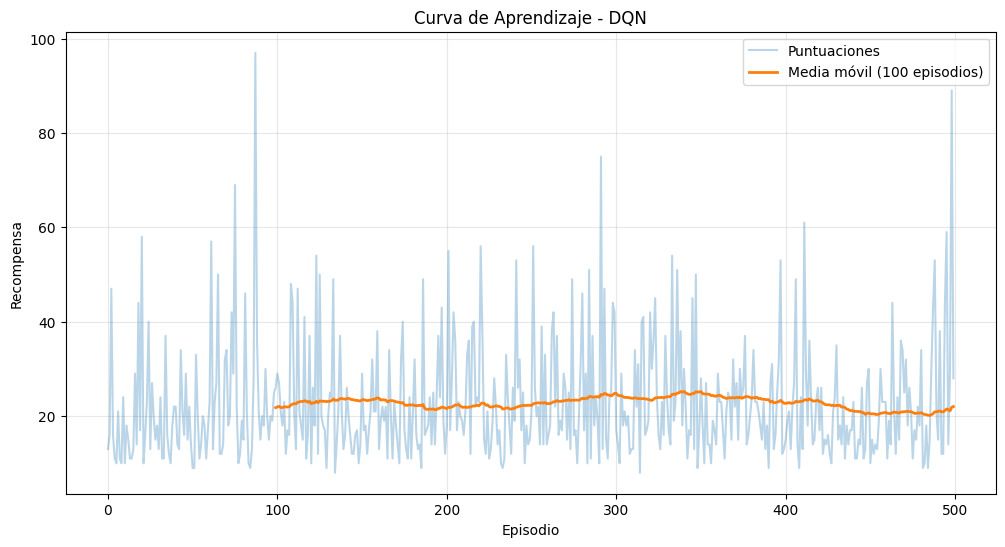

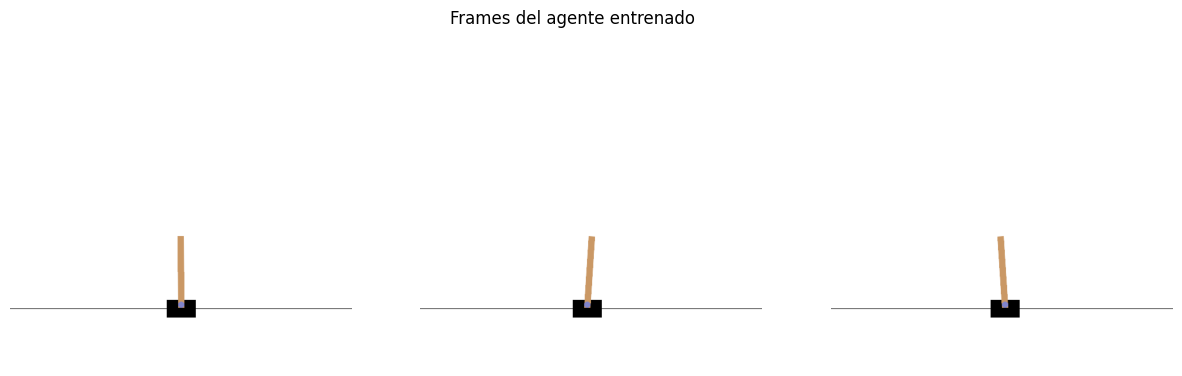


Entrenando DOUBLE_DQN...
TITLE  CartPole
Entrenando agente DOUBLE_DQN...
Episodio 100/500 | Score: 63.00 | Media móvil: 23.32
Episodio 110/500 | Score: 19.00 | Media móvil: 22.81
Episodio 120/500 | Score: 25.00 | Media móvil: 22.71
Episodio 130/500 | Score: 62.00 | Media móvil: 23.01
Episodio 140/500 | Score: 11.00 | Media móvil: 23.59
Episodio 150/500 | Score: 21.00 | Media móvil: 23.66
Episodio 160/500 | Score: 30.00 | Media móvil: 23.35
Episodio 170/500 | Score: 16.00 | Media móvil: 22.63
Episodio 180/500 | Score: 53.00 | Media móvil: 23.08
Episodio 190/500 | Score: 32.00 | Media móvil: 22.98
Episodio 200/500 | Score: 26.00 | Media móvil: 21.98
Episodio 210/500 | Score: 55.00 | Media móvil: 23.32
Episodio 220/500 | Score: 21.00 | Media móvil: 22.89
Episodio 230/500 | Score: 21.00 | Media móvil: 21.93
Episodio 240/500 | Score: 22.00 | Media móvil: 21.50
Episodio 250/500 | Score: 46.00 | Media móvil: 22.55
Episodio 260/500 | Score: 19.00 | Media móvil: 23.27
Episodio 270/500 | Score:

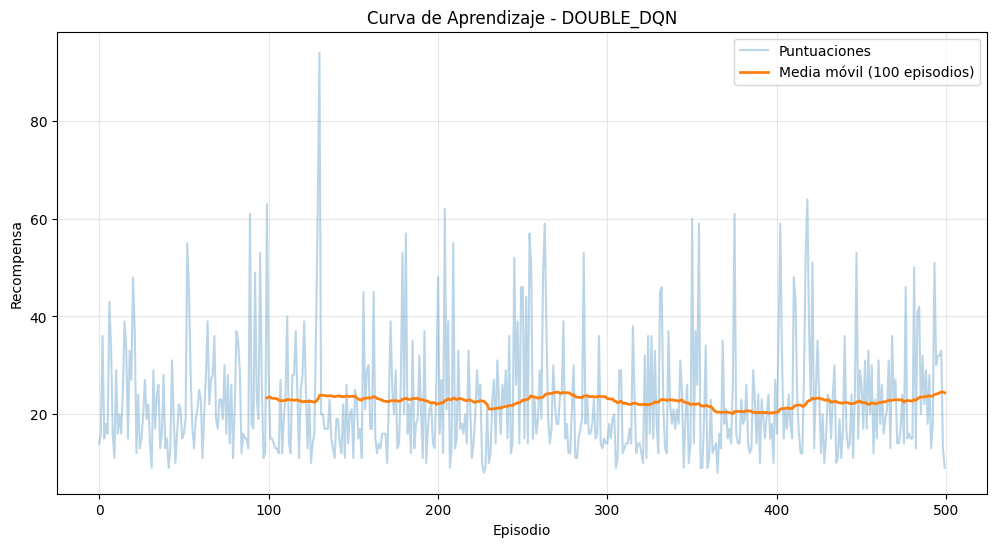

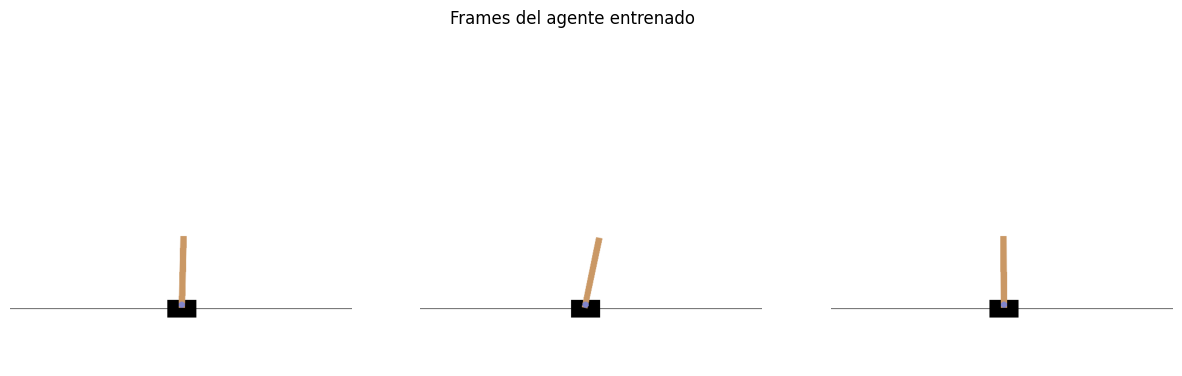


Entrenando DUELING_DQN...
TITLE  CartPole
Entrenando agente DUELING_DQN...
Episodio 100/500 | Score: 9.00 | Media móvil: 9.44
Episodio 110/500 | Score: 9.00 | Media móvil: 9.41
Episodio 120/500 | Score: 8.00 | Media móvil: 9.46
Episodio 130/500 | Score: 10.00 | Media móvil: 9.45
Episodio 140/500 | Score: 9.00 | Media móvil: 9.40
Episodio 150/500 | Score: 9.00 | Media móvil: 9.39
Episodio 160/500 | Score: 9.00 | Media móvil: 9.38
Episodio 170/500 | Score: 8.00 | Media móvil: 9.38
Episodio 180/500 | Score: 10.00 | Media móvil: 9.35
Episodio 190/500 | Score: 11.00 | Media móvil: 9.38
Episodio 200/500 | Score: 9.00 | Media móvil: 9.35
Episodio 210/500 | Score: 11.00 | Media móvil: 9.37
Episodio 220/500 | Score: 10.00 | Media móvil: 9.36
Episodio 230/500 | Score: 9.00 | Media móvil: 9.31
Episodio 240/500 | Score: 10.00 | Media móvil: 9.37
Episodio 250/500 | Score: 8.00 | Media móvil: 9.39
Episodio 260/500 | Score: 8.00 | Media móvil: 9.41
Episodio 270/500 | Score: 10.00 | Media móvil: 9.41

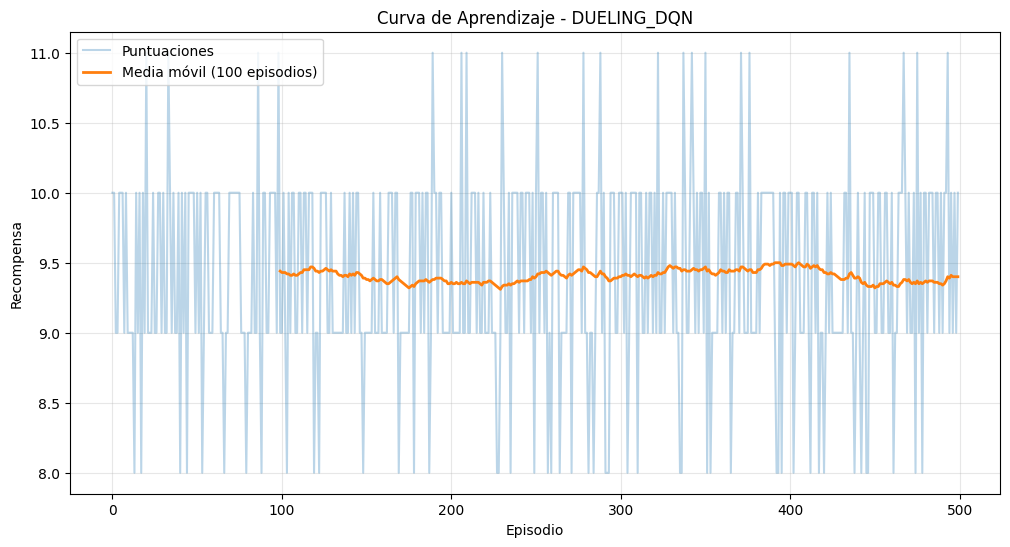

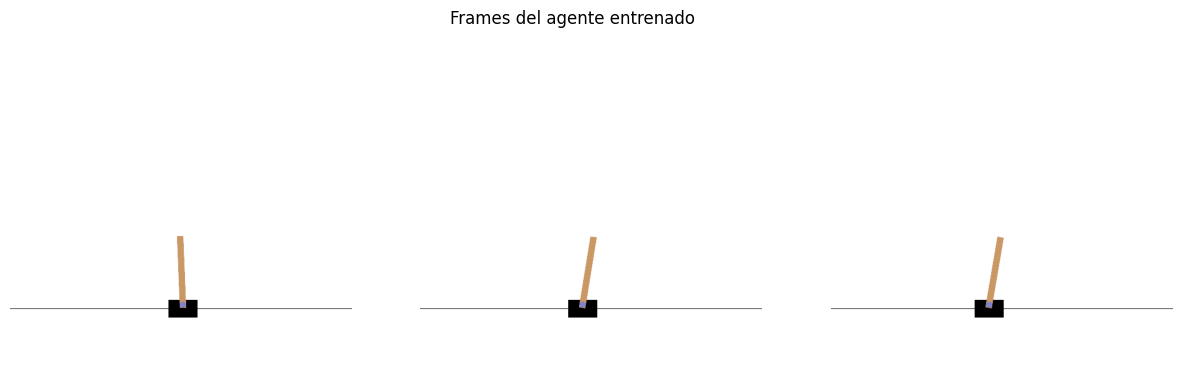


Resultados finales:
DQN: 22.61 ± 12.24
DOUBLE_DQN: 22.71 ± 12.03
DUELING_DQN: 9.42 ± 0.72


In [5]:
# Configuración del entrenamiento
num_episodes = 500  # Ajusta según necesites
window_size = 100   # Para la media móvil

# Diccionario para almacenar resultados
results = {}

# Lista de agentes a entrenar
agent_types = ['dqn', 'double_dqn', 'dueling_dqn']

# Entrenar cada tipo de agente
for agent_type in agent_types:
    print(f'\nEntrenando {agent_type.upper()}...')
    mean_score, std_score = train_and_evaluate(agent_type, num_episodes, window_size)
    results[agent_type] = (mean_score, std_score)

# Mostrar resultados finales
print('\nResultados finales:')
for agent_type, (mean, std) in results.items():
    print(f'{agent_type.upper()}: {mean:.2f} ± {std:.2f}')

## Comparación de Agentes

Visualizamos y comparamos el rendimiento de los diferentes agentes.

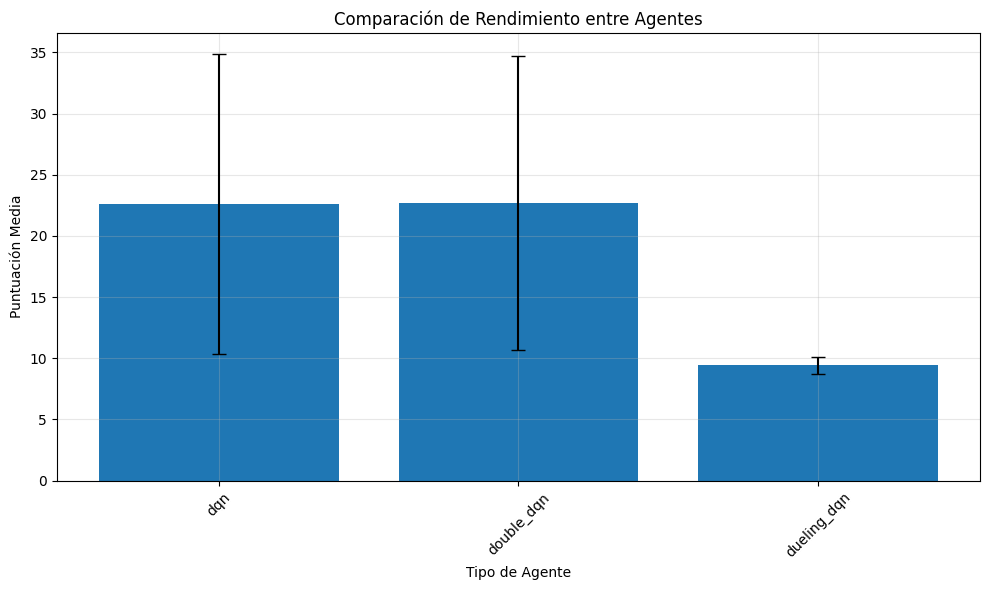

In [6]:
# Crear gráfico de barras comparativo
plt.figure(figsize=(10, 6))
agents = list(results.keys())
means = [results[agent][0] for agent in agents]
stds = [results[agent][1] for agent in agents]

plt.bar(agents, means, yerr=stds, capsize=5)
plt.title('Comparación de Rendimiento entre Agentes')
plt.xlabel('Tipo de Agente')
plt.ylabel('Puntuación Media')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()